[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Masao-Taketani/gan_practice/blob/master/dcgan.ipynb)


In [1]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization,\
Activation, Dropout, Flatten, Dense, Reshape, UpSampling2D, LeakyReLU,\
ZeroPadding2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
import numpy as np

from tensorflow.keras.datasets import mnist
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(x_train, _), (_, _) = mnist.load_data()
x_train.shape

(60000, 28, 28)

In [3]:
x_train = x_train/127.5 - 1.0
x_train = np.expand_dims(x_train, -1)
x_train.shape

(60000, 28, 28, 1)

In [0]:
# hyper params
input_dims = (28, 28, 1)
num_disc_layers = 4
disc_conv_fils = [32, 64, 128, 256]
disc_conv_kernel_size = [3, 3, 3, 3]
disc_conv_strides = [2, 2, 2, 1]
disc_batch_norm_momentum = 0.8
disc_dropout_rate = 0.25

z_dims = 100
shape_after_dense = (7, 7, 128)
gen_upsamp_layers = [True, True, False]
gen_batch_norm_momentum = 0.8
gen_dropout_rate = None
num_gen_layers = 3
gen_conv_fils = [128, 64, 1]
gen_conv_kernel_size = [3, 3, 3]

## Discriminator

In [5]:
disc_input = Input(shape=input_dims, name="disc_input")
x = disc_input

for i in range(num_disc_layers):
    x = Conv2D(filters=disc_conv_fils[i],
              kernel_size=disc_conv_kernel_size[i],
              strides=disc_conv_strides[i],
              padding="same",
              name="disc_conv_" + str(i)
              )(x)
    
    if i == 1:
        """
        Arguments:
        padding: Int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
        If int: the same symmetric padding is applied to height and width.
        If tuple of 2 ints: interpreted as two different symmetric padding values for height and width: (symmetric_height_pad, symmetric_width_pad).
        If tuple of 2 tuples of 2 ints: interpreted as ((top_pad, bottom_pad), (left_pad, right_pad))
        """
        x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
        
    if disc_batch_norm_momentum and i > 0:
        x = BatchNormalization(momentum=disc_batch_norm_momentum)(x)
        
    x = LeakyReLU(alpha=0.2)(x)
    
    if disc_dropout_rate:
        x = Dropout(disc_dropout_rate)(x)
    
x = Flatten()(x)
disc_output = Dense(1, activation="sigmoid")(x)
disc_model = Model(disc_input, disc_output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
disc_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
disc_input (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
disc_conv_0 (Conv2D)         (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
disc_conv_1 (Conv2D)         (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256   

## Generator

In [0]:
gen_input = Input(shape=(z_dims,), name="gen_input")
x = gen_input
x = Dense(np.prod(shape_after_dense))(x)
    
x = Activation("relu")(x)
x = Reshape(shape_after_dense)(x)
    
for i in range(num_gen_layers):
    if gen_upsamp_layers[i]:
        x = UpSampling2D()(x)
        
    x = Conv2D(gen_conv_fils[i],
              gen_conv_kernel_size[i],
              padding="same",
              name="gen_conv_" + str(i)
              )(x)
    
    if i < num_gen_layers - 1:
        if gen_batch_norm_momentum:
            x = BatchNormalization(
            momentum=gen_batch_norm_momentum)(x)
            
        x = Activation("relu")(x)
    else:
        x = Activation("tanh")(x)
        
gen_output = x
gen_model = Model(gen_input, gen_output)

In [8]:
gen_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
activation (Activation)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
gen_conv_0 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512 

## Train the GAN

### compile discriminator train model

In [9]:
disc_model.compile(#optimizer=RMSprop(lr=0.0008),
                  optimizer=Adam(0.0002, 0.5),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# freeze the discriminator model so that it only makes
# the generator model train on this model
disc_model.trainable = False
comb_model_input = Input(shape=(z_dims,), name="comb_model_input")
comb_model_output = disc_model(gen_model(comb_model_input))
comb_model = Model(comb_model_input, comb_model_output)

### compile generator train model

In [0]:
comb_model.compile(#optimizer=RMSprop(0.0004),
             optimizer=Adam(0.0002, 0.5),
             loss="binary_crossentropy",
             metrics=["accuracy"])

In [0]:
def train_disc(disc_model, gen_model, x_train, batch_size):
    # create 2-dim labels
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    # train on real imgs
    # np.random.randint(min, max, size)
    idxes = np.random.randint(0, len(x_train), batch_size)
    real_imgs = x_train[idxes]
    
    disc_real_loss = disc_model.train_on_batch(real_imgs, real_labels)
    
    # train on fake imgs
    # np.random.normal(mean, std, size)
    # the blow follows the standard normal distribution
    noise = np.random.normal(0, 1, (batch_size, z_dims))
    fake_imgs = gen_model.predict(noise)
    
    disc_fake_loss = disc_model.train_on_batch(fake_imgs, fake_labels)
    disc_loss = 0.5 * np.add(disc_real_loss, disc_fake_loss)
    return disc_loss

In [0]:
def train_gen(comb_model, batch_size):
    real_labels = np.ones((batch_size, 1))
    noise = np.random.normal(0, 1, (batch_size, z_dims))
    
    gen_loss = comb_model.train_on_batch(noise, real_labels)
    return gen_loss

In [0]:
def plot_generated_img(noise):
    result_img = gen_model.predict(noise)
    reshaped_img = np.reshape(result_img, list(input_dims[:2]))
    orig_form_img = 127.5 * (reshaped_img + 1.0)
    pil_img = Image.fromarray(orig_form_img)
    plt.imshow(pil_img, cmap="gray")

iteration: 0 disc loss: 1.011379, disc acc: 43.75% | gen loss: 0.691659, gen acc: 0.64%
iteration: 500 disc loss: 0.689421, disc acc: 57.81% | gen loss: 0.898341, gen acc: 0.45%
iteration: 1000 disc loss: 0.584620, disc acc: 70.31% | gen loss: 1.050551, gen acc: 0.25%
iteration: 1500 disc loss: 0.642192, disc acc: 63.28% | gen loss: 1.047473, gen acc: 0.23%
iteration: 2000 disc loss: 0.667796, disc acc: 61.72% | gen loss: 1.191339, gen acc: 0.16%
iteration: 2500 disc loss: 0.667364, disc acc: 60.16% | gen loss: 0.919771, gen acc: 0.28%
iteration: 3000 disc loss: 0.637137, disc acc: 60.16% | gen loss: 0.904084, gen acc: 0.27%
iteration: 3500 disc loss: 0.597010, disc acc: 70.31% | gen loss: 1.010860, gen acc: 0.25%


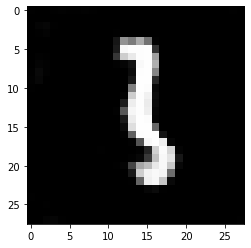

In [15]:
iterations = 4000
batch_size = 64
test_noise = np.random.normal(0, 1, (1, z_dims))

for it in range(iterations):
    disc_loss = train_disc(disc_model, gen_model, x_train, batch_size)
    gen_loss = train_gen(comb_model, batch_size)
    
    if it % 500 == 0:
        print("iteration: %d disc loss: %f, disc acc: %.2f%% | gen loss: %f, "
        "gen acc: %.2f%%" % 
          (it, disc_loss[0], 100 * disc_loss[1], gen_loss[0], gen_loss[1]))
        
plot_generated_img(test_noise)